In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import gc

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr/decoder_best.pt
/kaggle/input/flickr/encoded.csv
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Readme.txt
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr8k.lemma.token.txt
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr8k.token.txt
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flicker8k_Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flicker8k_Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flicker8k_Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr/Flickr8K-20210412T103202Z-0

In [3]:
import os
import cv2

data = []
label = []
path = '../input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flicker8k_Images/'
for y in os.listdir(path):
    img_path = path + y
    image = cv2.imread(img_path)
    if image is not None:
        image = cv2.resize(image, (227, 227))
        data.append(np.array(image))
        label.append(y[:-4])

In [4]:
combined_data = []

for i in range(len(data)):
    arr = np.zeros((3, 227, 227), dtype = int)
    arr = np.transpose(data[i],(2,0,1))
    combined_data.append((arr, label[i]))

del data
gc.collect()

0

In [5]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def batch_generator(curr_batch):
    images = []
    labels = []
    for x in curr_batch:
        images.append(preprocess(np.uint8(x[0])))
        labels.append(x[1])
    images = [t.numpy() for t in images]
    images = torch.tensor(images, dtype = torch.float32)
    return images, labels

class data_convert(Dataset):
    def __init__(self, data):
        self.dataframe = data
    
    def __getitem__(self, ind):
        return self.dataframe[ind]
    
    def __len__(self):
        return len(self.dataframe)

In [6]:
import torch
data = data_convert(combined_data)
dataloader = torch.utils.data.DataLoader(data, batch_size = 32, shuffle = True, collate_fn = batch_generator)
del combined_data
del data
gc.collect()

28

In [7]:
my_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.mobilenet_v2(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [9]:
encoder = Encoder()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [10]:
db = {}
encoder.to(my_device)
with torch.no_grad():
  for data in dataloader:
      inputs, labels = data
      inputs = inputs.to(my_device)
      outputs = encoder(inputs)
      for i,features in enumerate(outputs):
        db[labels[i]] = features

In [155]:
import torch
from torch import nn
import torchvision
import random

class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5,teacher_forcing_ratio = 1):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        for p in self.embedding.parameters():
            p.requires_grad = True
        
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
            

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        preds = embeddings[:,0,:]
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = preds.argmax(1)
            embeds_temp = self.embedding(top1)
            next_input = embeddings[:batch_size_t, t, :] if teacher_force else embeds_temp[:batch_size_t,:]
            h, c = self.decode_step(
                torch.cat([next_input, attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [12]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # store the first description for each image
        if image_id not in mapping:
            mapping[image_id] = image_desc
    return mapping
 
filename = '../input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [13]:
def load_all_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # store the first description for each image
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

In [14]:
f1 = '../input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt'
f2 = '../input/flickr/Flickr8K-20210412T103202Z-001/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt'
doc = load_doc(f1)
training = doc.split('\n')
doc = load_doc(f2)
validation = doc.split('\n')
doc = load_doc(filename)
all_desc = load_all_descriptions(doc)

In [15]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for i in descriptions:
    counter.update(tokenizer(descriptions[i]))
start_and_end = '<start> <end>'
counter.update(tokenizer(start_and_end))
vocab = Vocab(counter, min_freq=1)

In [16]:
def generate_combined_train(labels):
    combined_data = []
    for i in labels:
        if i[:-4] in list(db.keys()):
            combined_data.append((db[i[:-4]],descriptions[i[:-4]]))
    return combined_data

def generate_combined_val(labels,labels_all):
    combined_data = []
    for i in labels:
        if i[:-4] in list(db.keys()):
            combined_data.append((db[i[:-4]],descriptions[i[:-4]],labels_all[i[:-4]]))
    return combined_data

In [17]:
train_data = generate_combined_train(training)
validation_data = generate_combined_val(validation,all_desc)

In [18]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [19]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    encoding_list, offsets = [], []
    pad_token = vocab['<pad>']
    lens = [len(tokenizer(text)) for (encoding,text) in batch]
    batch_size = len(lens)
    longest_sent = max(lens) + 2
    padded_text = np.ones((batch_size, longest_sent)) * pad_token
    for i,(_encoding, _text) in enumerate(batch):
         encoding_list.append(_encoding)
         temp_text = '<start> ' + _text + ' <end>'  
         sentence_length = len(tokenizer(temp_text))
         processed_text = torch.tensor(text_pipeline(temp_text), dtype=torch.int64)
         padded_text[i,:sentence_length] = processed_text
         offsets.append([processed_text.size(0)])
    encoding_list = torch.tensor([t.to(torch.device('cpu')).numpy() for t in encoding_list])
    offsets = torch.tensor(offsets)
    padded_text = torch.tensor(padded_text,dtype=torch.int64)
    return encoding_list.to(device), padded_text.to(device), offsets.to(device)

def collate_batch_val(batch):
    encoding_list, offsets = [], []
    pad_token = vocab['<pad>']
    lens = [len(tokenizer(text)) for (encoding,text,x) in batch]
    batch_size = len(lens)
    longest_sent = max(lens) + 2
    padded_text = np.ones((batch_size, longest_sent)) * pad_token
    longest_all_caps = max([len(tokenizer(text)) for (encoding,text1,x) in batch for text in x]) + 2
    max_caps = max([len(x) for (encoding,text,x) in batch])
    padded_all_caps = np.ones((batch_size, max_caps,longest_all_caps)) * vocab['<pad>']
    for i,(_encoding, _text, _caps) in enumerate(batch):
         encoding_list.append(_encoding)
         temp_text = '<start> ' + _text + ' <end>'  
         sentence_length = len(tokenizer(temp_text))
         processed_text = torch.tensor(text_pipeline(temp_text), dtype=torch.int64)
         padded_text[i,:sentence_length] = processed_text
         offsets.append([processed_text.size(0)])
         for j,_cap in enumerate(_caps):
                temp_text = '<start> ' + _cap + ' <end>'  
                sentence_length = len(tokenizer(temp_text))
                processed_text = torch.tensor(text_pipeline(temp_text), dtype=torch.int64)
                padded_all_caps[i,j,:sentence_length] = processed_text
    encoding_list = torch.tensor([t.to(torch.device('cpu')).numpy() for t in encoding_list])
    offsets = torch.tensor(offsets)
    padded_text = torch.tensor(padded_text,dtype=torch.int64)
    padded_all_caps = torch.tensor(padded_all_caps,dtype=torch.int64)
    return encoding_list.to(device), padded_text.to(device), offsets.to(device),padded_all_caps.to(device)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=False, collate_fn=collate_batch_val)

In [314]:
decoder = DecoderWithAttention(512,512,512,len(vocab),1280)
decoder.to(device)

DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=1280, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(4527, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(1792, 512)
  (init_h): Linear(in_features=1280, out_features=512, bias=True)
  (init_c): Linear(in_features=1280, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=1280, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=4527, bias=True)
)

In [228]:
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)

In [317]:
# if os.path.exists('../input/flickr/decoder.pt'):
model_dicts = torch.load('../input/flickr/decoder_last.pt')
decoder.load_state_dict(model_dicts)
# decoder_optimizer.load_state_dict(model_dicts['decoder_optimizer_state_dict'])

<All keys matched successfully>

In [23]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [24]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [25]:
alpha_c = 1.0

In [68]:
import time
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu


def validate(val_loader, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()
    top1accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (encodings, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            encodings = encodings.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encodings, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores.data, targets.data)

#             # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores.data, targets.data, 5)
            top5accs.update(top5, sum(decode_lengths))
            top1 = accuracy(scores.data,targets.data,1)
            top1accs.update(top1,sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))
            
                print('Top-1 Accuracy {top1.val:.3f} ({top1.avg:.3f})'.format(top1=top1accs))


            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {vocab['<start>'], vocab['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = 0
        cnt=0
        for i in range(len(references)):
            cnt+=1
            bleu4+=sentence_bleu(references[i],hypotheses[i])
        bleu4/=cnt
        print('\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [27]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [28]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [286]:
print_freq=100

batch_time = AverageMeter()  # forward prop. + back prop. time
data_time = AverageMeter()  # data loading time
losses = AverageMeter()  # loss (per word decoded)
top5accs = AverageMeter()  # top5 accuracy
top1accs = AverageMeter()
grad_clip = 5.

epochs_since_improvement = 0
best_bleu = 0

# adjust_learning_rate(decoder_optimizer,0.8)

start = time.time()
for epoch in range(2):
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
    decoder.train()
    for i, (encodings, caps, caplens) in enumerate(train_dataloader):

        # Move to GPU, if available
        encodings = encodings.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        
        # Forward prop.
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encodings, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores.data, targets.data)

#         # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
#             if encoder_optimizer is not None:
#                 clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()

        # Keep track of metrics
        top1 = accuracy(scores.data,targets.data,1)
        top5 = accuracy(scores.data, targets.data, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        top1accs.update(top1,sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()
        
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_dataloader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))
            print('Top-1 Accuracy {top1.val:.3f} ({top1.avg:.3f})'.format(top1=top1accs))
        
    bleu4 = validate(validation_dataloader,decoder,criterion)
    did_improve = bleu4 > best_bleu
    best_bleu = max(best_bleu,bleu4)
    if not did_improve:
        epochs_since_improvement+=1
    else:
        epochs_since_improvement=0

Epoch: [0][0/188]	Batch Time 1.733 (1.733)	Data Load Time 0.000 (0.000)	Loss 4.7266 (4.7266)	Top-5 Accuracy 52.439 (52.439)
Top-1 Accuracy 34.146 (34.146)
Epoch: [0][100/188]	Batch Time 1.751 (1.776)	Data Load Time 0.000 (0.000)	Loss 4.4385 (4.6794)	Top-5 Accuracy 60.000 (54.157)
Top-1 Accuracy 39.259 (35.640)
Validation: [0/32]	Batch Time 1.726 (1.726)	Loss 4.7083 (4.7083)	Top-5 Accuracy 53.086 (53.086)	
Top-1 Accuracy 33.539 (33.539)

 * LOSS - 4.657, TOP-5 ACCURACY - 55.122, BLEU-4 - 0.5128078633282119

Epoch: [1][0/188]	Batch Time 56.619 (2.062)	Data Load Time 0.000 (0.000)	Loss 4.7912 (4.6659)	Top-5 Accuracy 54.651 (54.381)
Top-1 Accuracy 33.721 (35.924)
Epoch: [1][100/188]	Batch Time 1.740 (1.963)	Data Load Time 0.000 (0.000)	Loss 4.6632 (4.6367)	Top-5 Accuracy 54.767 (54.730)
Top-1 Accuracy 34.590 (36.153)
Validation: [0/32]	Batch Time 1.714 (1.714)	Loss 4.6495 (4.6495)	Top-5 Accuracy 53.909 (53.909)	
Top-1 Accuracy 33.951 (33.951)

 * LOSS - 4.595, TOP-5 ACCURACY - 55.832, BLEU

In [162]:
bleu4 = validate(validation_dataloader,decoder,criterion)

Validation: [0/32]	Batch Time 1.724 (1.724)	Loss 4.2051 (4.2051)	Top-5 Accuracy 60.905 (60.905)	
Top-1 Accuracy 38.477 (38.477)

 * LOSS - 4.151, TOP-5 ACCURACY - 62.095, BLEU-4 - 0.4954784873483898



In [99]:
# torch.save({'model_state_dict':decoder.state_dict(),'decoder_optimizer_state_dict':decoder_optimizer.state_dict()}, 'decoder.pt')
torch.save(decoder.state_dict(), 'decoder.pt')

In [325]:
data = []
path = '../input/flickr/subjective_img/subjective_img/'
for y in os.listdir(path):
    img_path = path + y
    image = cv2.imread(img_path)
    if image is not None:
        image = cv2.resize(image, (227, 227))
        data.append(image)
# image = cv2.imread('../input/flickr/subjective_img/subjective_img/sample5.jpg')
# if image is not None:
#     image = cv2.resize(image, (227, 227))
#     data.append(image)

In [326]:
for i in range(len(data)):
    data[i] = preprocess(np.uint8(data[i]))

In [327]:
data = [t.numpy() for t in data]
data = torch.tensor(data, dtype = torch.float32)
data = data.to(my_device)

In [328]:
data1 = data
data1 = data1.to(torch.device('cpu'))

In [329]:
from tqdm import tqdm
import torch.nn.functional as F

def evaluate(loader,beam_size,word_map): 
    decoder.eval()
    
    hypotheses = list()
    vocab_size = len(vocab)
    # For each image
    attentions = []
    for i, (image) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size        
        image = image.unsqueeze(dim=0)

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        complete_attention = []
        attention_outputs = torch.zeros(k,51,num_pixels).to(device)
        step = 1
        mean_encoder_out = encoder_out.mean(dim=1)
        h = decoder.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = decoder.init_c(mean_encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:
#             attention_temp = torch.zeros(k,num_pixels)

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)
            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words // vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            next_word_inds1 = top_k_words

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
            attention_outputs = attention_outputs[prev_word_inds]
            attention_outputs[:,step,:] = alpha[prev_word_inds]

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_attention.extend(attention_outputs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            attention_outputs = attention_outputs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        attentions.append(complete_attention[i])
        seq = complete_seqs[i]
        
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
    return hypotheses,attentions

In [371]:
def generate_caps(image,caps,vocab):
    image = image.unsqueeze(dim=0)

    # Move to GPU device, if available
    image = image.to(device)  # (1, 3, 256, 256)

    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    
    encodings = encoder_out
    caps = torch.tensor([vocab[x] for x in caps]).unsqueeze(0).to(device)
    caplens = torch.tensor([caps.shape[1]]).unsqueeze(1).to(device)

    # Forward prop.
#     print(encodings.shape,caps.shape,caplens.shape)
    scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encodings, caps, caplens)
#     print(scores.shape)
    _,index = scores.topk(1,dim=2)
    return index

In [449]:
cap = tokenizer('<sos> A group of people sitting on a bench . <eos>')
gen_captions = generate_caps(data[2],cap,vocab)
print(gen_captions.shape)

torch.Size([1, 10, 1])


In [450]:
# gen_captions.squeeze(0).squeeze(1)
[vocab.itos[x] for x in gen_captions.squeeze(0).squeeze(1)]

['a', 'man', 'of', 'people', 'are', 'on', 'a', 'bench', '.', '<end>']

In [524]:
# torch.cuda.empty_cache()
hypotheses,attentions = evaluate(data,5,vocab)
attentions = torch.tensor(attentions)

EVALUATING AT BEAM SIZE 5: 100%|██████████| 5/5 [00:00<00:00, 25.85it/s]


In [525]:
attentions.shape

torch.Size([5, 51, 196])

In [526]:
caps = []
for i in range(len(hypotheses)):
    caps.append([])
    for j in range(len(hypotheses[i])):
        caps[i].append(vocab.itos[hypotheses[i][j]])

['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'jeans', 'sits', 'on', 'a', 'bench', '.']
['a', 'girl', 'in', 'a', 'red', 'shirt', 'is', 'a', '.']
['a', 'group', 'of', 'people', 'stand', 'in', 'the', 'street', '.']
['a', 'brown', 'and', 'white', 'dog', 'is', 'jumping', 'over', 'a', 'hurdle', '.']
['a', 'black', 'and', 'white', 'dog', 'is', 'in', 'the', 'snow', '.']


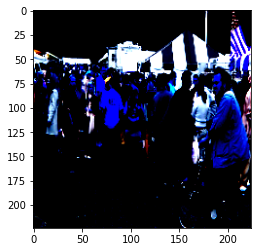

In [527]:
import matplotlib.pyplot as plt
for i in range(len(caps)):
    print(caps[i])
    img = data1[0]
    plt.imshow(np.transpose(img,(1,2,0)))

In [ ]:
model_dicts = torch.load('./decoder.pt')

In [ ]:
decoder1 = DecoderWithAttention(512,512,512,len(vocab),1280)
decoder1.load_state_dict(model_dicts['model_state_dict'])
decoder_optimizer1 = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()))
decoder_optimizer1.load_state_dict(model_dicts['decoder_optimizer_state_dict'])

In [ ]:
decoder_optimizer1

In [531]:
def plot_attention(img, result, attention_plot):
    #untransform
    
    img = img.transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,-1)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

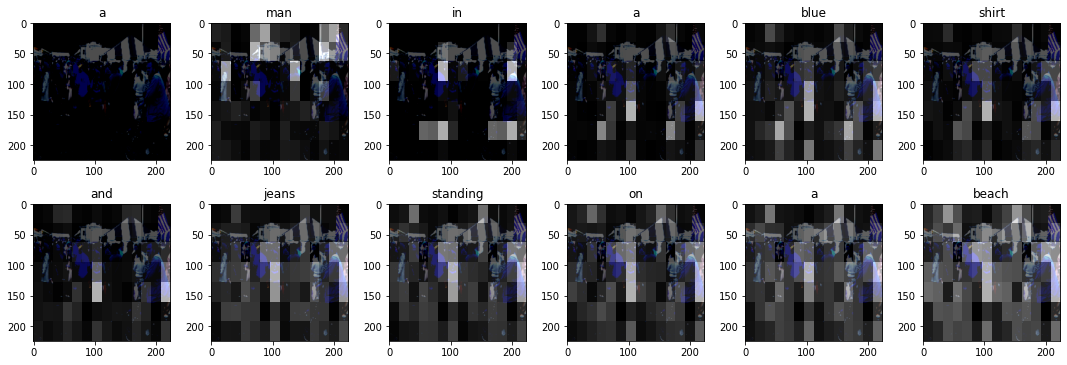

In [535]:
plot_attention(data[0].to('cpu').numpy(),tokenizer('a man in a blue shirt and jeans standing on a beach'),attentions[0].unsqueeze(1))

In [ ]:
# sentence_bleu([tokenizer('<sos> A man is riding a cycle through a market . <eos>')],tokenizer('a man in a '))

In [ ]:
# plt.imshow(data[0].to('cpu').numpy().transpose(1,2,0))
# encoded_outputs = encoder(data[0].unsqueeze(0))
# encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
# num_pixels = encoder_out.size(1)
# mean_encoder_out = encoder_out.mean(dim=1)
# step=1
# h = decoder.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
# c = decoder.init_c(mean_encoder_out)
# attention_outputs = []
# while True:
#     embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

#     awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

#     gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
#     awe = gate * awe

#     h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

#     scores = decoder.fc(h)  # (s, vocab_size)
#     scores = F.log_softmax(scores, dim=1)
#     attention_outputs.append(awe)